## Import libararies

In [1193]:
import pandas as pd
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd 
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
from numpy import linalg

from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix as plotConfustionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Required Functions

In [1194]:
class Node:
    def __init__(self, child = np.array([]), data = None, label = None, attributes = None):
        self.child = child
        self.data = data
        self.label = label
        self.attributes = attributes

In [1195]:
def grow_node(root, attribute, threshold):
  if(len(threshold[attribute]) == 2):
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][0]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] == threshold[attribute][1]]))], axis = 0)
    
  else:
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][0]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][1]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][2]]))], axis = 0)

In [1196]:
def encode_data(data, flag = 'library'):
  encoded_data = []
  for i in range(FEATURE):
    if flag == 'library':
      label_encoder = preprocessing.LabelEncoder()
      label_encoder.fit(train_data.T[i])
      encoded_data.append(label_encoder.transform(train_data.T[i]))
    else:
      encoded_data.append([dict([(y, x) for x, y in enumerate(sorted(set(train_data.T[i])))])[x] for x in train_data.T[i]])

  return encoded_data

In [1197]:
def split_data(data,size_percent,label_column):
  train_data_size = int(np.floor(data.shape[0]*size_percent))
  indexes = random.sample(range(0, data.shape[0]), train_data_size)
  indexes.sort()

  train = data[indexes]
  train_data, train_label = train[:, :], train[:,label_column]
  listed_data = data.tolist()
  for i in range(train_data_size): listed_data.pop(indexes[i] - i)
  test = np.array(listed_data)
  test_data, test_label = test[:, :], test[:,label_column]
  return train_data, test_data, train_label, test_label

In [1198]:
def entropy(target_node):
    elements, counts = np.unique(target_node, return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [1199]:
def information_gain(root):
  total_entropy = entropy(root.data.T[-1])
  reduction = np.sum([(child.data.shape[0] / root.data.shape[0]) * entropy(child.data.T[-1]) for child in root.child if not child.data.shape[0] == 0], axis = 0)
  gain = total_entropy - reduction
  return gain

In [1200]:
def find_best_attribute(root, threshold):
  information = np.array([])
  for attr in range(len(root.data[0]) - 1):
      temp_node = Node(data = root.data, label = root.label, attributes = root.attributes)
      grow_node(temp_node, attr, threshold)
      information = np.append(information, [information_gain(temp_node)], axis=0)
      best_attibute = np.argmax(information)
  return best_attibute

In [1201]:
def calculate_threshold(train_data):
  threshold = []
  for i in range(train_data.shape[1]):
      unique_attribute = np.unique(train_data[:, i])
      threshold.append(unique_attribute)
  return threshold

In [1202]:
def confusion_matrix(actual, predicted):
    classes = np.unique(actual)
    confmat = np.zeros((len(classes), len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
           confmat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))
    return confmat

## Implementing ID3 algorithm

In [1203]:
def ID3(train_data, max_depth, threshold):
        root = Node(data = train_data)
        if (root.data.T[-1].all() == True):
            root.label = 1
            return root
        if (root.data.T[-1].any() == False):
            root.label = 0
            return root
        if(max_depth == 0):
            root.label = 1*((root.data.T[-1] == 1).sum() > (root.data.T[-1] == 0).sum())
            return root
        attribute = find_best_attribute(root, threshold)
        root.attributes = attribute
        if(len(threshold[attribute]) == 2):
            root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][0]]), max_depth-1, threshold)], axis = 0)
            root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][1]]), max_depth-1, threshold)], axis = 0)
        else:
            root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][0]]), max_depth-1, threshold)], axis = 0)
            root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][1]]), max_depth-1, threshold)], axis = 0)
            root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][2]]), max_depth-1, threshold)], axis = 0)
        return root

In [1204]:
def move_along_tree(test_data, tree, threshold):
  if tree.label != None : return tree.label
  else:
    if len(threshold[tree.attributes]) == 2 :
      return move_along_tree(test_data, tree.child[0], threshold) if test_data[tree.attributes] == threshold[tree.attributes][0] else move_along_tree(test_data, tree.child[1], threshold)
    else:
        if test_data[tree.attributes] == threshold[tree.attributes][0]: return move_along_tree(test_data, tree.child[0], threshold)
        elif test_data[tree.attributes] == threshold[tree.attributes][1]: return move_along_tree(test_data, tree.child[1], threshold)
        else: return move_along_tree(test_data, tree.child[2], threshold)
        

In [1205]:
def test_trained_tree(train_data, test_data, final_tree):
  return [move_along_tree(test_data[i], final_tree, threshold) for i in range(len(test_data))]

In [1206]:
def getAccuracy(predicts_label,test_data):
    return (predicts_label == test_data[:, -1].astype(int)).mean()*100

## Reading Data & Shuffling

In [1207]:
data = pd.read_csv('prison_dataset.csv')
data = data.to_numpy()
np.random.shuffle(data)
train_data, test_data, train_label, test_label = split_data(data,0.8,10)
encoded_train_data = np.array(encode_data(train_data)).T
encoded_test_data = np.array(encode_data(test_data)).T
FEATURE = 11
K = 3
SIZE = 11/K

In [1208]:
threshold = calculate_threshold(encoded_train_data)
max_depth = 3
final_tree = ID3(encoded_train_data, max_depth, threshold)

In [1209]:
predicted_labels = test_trained_tree(encoded_train_data, encoded_test_data, final_tree)

print('Accuracy of Decision Tree is: %% %1.2f' %(getAccuracy(predicted_labels, encoded_test_data)))

Accuracy of Decision Tree is: % 72.36


In [1210]:
def make_confusion_matrix(test_labels, predicted_labels):
  class_labels = np.unique(test_labels)  
  return np.array([[np.sum((test_labels == class_labels[i]) & (predicted_labels == class_labels[j])) for j in range(len(class_labels))] for i in  range(len(class_labels))]) 

In [1211]:
def plot_confusion_matrix(matrix, classes, normalize=False, title='Confusion matrix', cmap = plt.cm.Purples):
    plt.figure(figsize = (6,6))
    plt.imshow(matrix, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 10, fontweight = 'bold')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='lavender' if matrix[i,j]>thresh else 'mediumpurple')
    plt.ylabel('True predictions', fontsize = 10, fontweight = 'bold')
    plt.xlabel('Predicted Lables', fontsize = 10, fontweight = 'bold')
    plt.show()

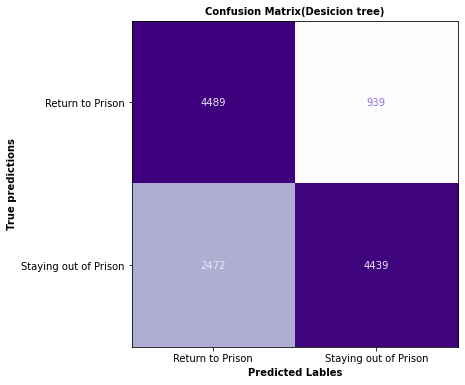

In [1212]:
confusion_matrix = make_confusion_matrix(encoded_test_data[:,-1], predicted_labels)
plot_confusion_matrix(confusion_matrix, ['Return to Prison', 'Staying out of Prison'], title = 'Confusion Matrix(Desicion tree)')

## Part 2: Random Forest without libararies

In [1213]:
def ID3_random_forest(train_data, max_depth, threshold, k):
    
    root = Node(data = train_data)
    if not len(np.array(root.data)) == 0:
      if (root.data.T[-1].all() == True):
        root.label = 1
        return root
      if (root.data[-1].any() == False):
        root.label = 0
        return root
      if(max_depth == 0):
        root.label = 1*((root.data[-1] == 1).sum() > (root.data.T[-1] == 0).sum())
        return root
    else : return root
    attribute = find_best_attribute(root, threshold)
    new_attribute = attribute + int(k*SIZE)
    root.attributes = new_attribute
    if(len(threshold[new_attribute]) == 2):
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][0]]), max_depth-1, threshold, k)], axis = 0)
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][1]]), max_depth-1, threshold, k)], axis = 0)
    else:
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][0]]), max_depth-1, threshold, k)], axis = 0)
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][1]]), max_depth-1, threshold, k)], axis = 0)
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][2]]), max_depth-1, threshold, k)], axis = 0)
    return root

In [1214]:
K = 3
SIZE = 11/K
final_tree = [ID3_random_forest(np.column_stack((encoded_train_data[:, int(K*SIZE):int((K+1)*SIZE)], encoded_train_data[:,-1])), 3, threshold, k) for k in range(K)]
final_predictions = []
for en in range(len(encoded_test_data)):
  predictions = [(move_along_tree(encoded_train_data[en], final_tree[k], threshold)) for k in range(K)]
  final_predictions.append(1*((np.array(predictions) == 1).sum() > (np.array(predictions) == 0).sum()))


In [1215]:
print('Accuracy of Random Forest with k = ', K , 'is: %% %1.2f' %(getAccuracy(final_predictions, encoded_test_data)))

Accuracy of Random Forest with k =  3 is: % 43.99


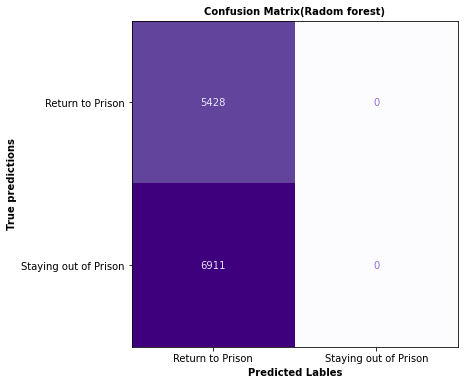

In [1216]:
confusion_matrix = make_confusion_matrix(encoded_test_data[:,-1], final_predictions)
plot_confusion_matrix(confusion_matrix, ['Return to Prison', 'Staying out of Prison'], title = 'Confusion Matrix(Radom forest)')

## Part 3: Random Forest with libararies

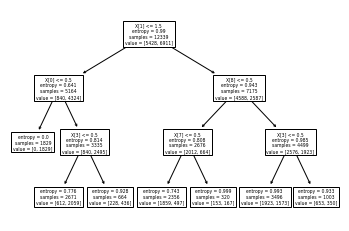

In [1217]:
clf = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0, max_depth = 3)
clf = clf.fit(encoded_train_data[:,:-1], encoded_test_data[:,-1])
tree.plot_tree(clf);

In [1218]:
y_pred = clf.predict(encoded_test_data[:,:-1])
accuracy = (y_pred == encoded_test_data[:, -1].astype(int)).mean()
print('Accuracy of Decision Tree using sklearn is: %% %1.2f' %(accuracy*100))

Accuracy of Decision Tree using sklearn is: % 72.34


In [1219]:
def plot_confusion_matrix_sk(clf, test_data, test_label, matrix_labels, matrix_title):
  disp = plotConfustionMatrix(clf, test_data, test_label, display_labels = matrix_labels, cmap=plt.cm.Purples)
  disp.ax_.set_title(matrix_title)
  plt.show()

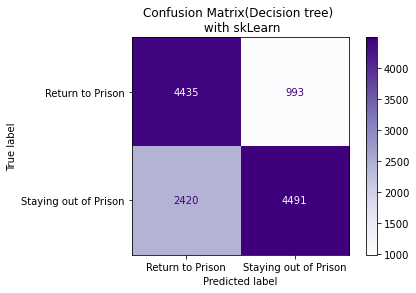

In [1220]:
plot_confusion_matrix_sk(clf, encoded_train_data[:,:-1], encoded_test_data[:,-1], ['Return to Prison', 'Staying out of Prison'],  'Confusion Matrix(Decision tree) \n with skLearn')

In [1221]:
clf_rf = RandomForestClassifier(random_state = 0, max_depth = 3)
clf_rf = clf_rf.fit(encoded_train_data[:,:-1], encoded_test_data[:,-1])

In [1222]:
y_pred = clf_rf.predict(encoded_test_data[:,:-1])
accuracy_rf = (y_pred == encoded_test_data[:, -1]).mean()
print('Accuracy of Random Forest using sklearn is: %% %1.2f' %(accuracy_rf*100))

Accuracy of Random Forest using sklearn is: % 72.35


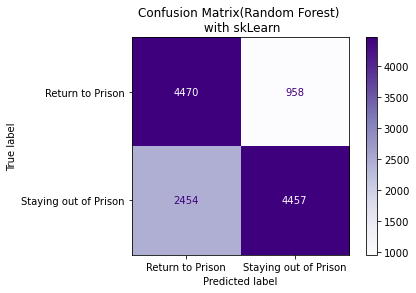

In [1223]:
plot_confusion_matrix_sk(clf_rf, encoded_train_data[:,:-1], encoded_test_data[:,-1], ['Return to Prison', 'Staying out of Prison'],  'Confusion Matrix(Random Forest) \n with skLearn')